In [6]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import os
import urllib, zipfile, shutil
import random

In [5]:
url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
zip_path = "tiny-imagenet-200.zip"
data_dir = "tiny-imagenet-200"

if not os.path.exists(data_dir):
    print("Downloading Tiny ImageNet...")
    urllib.request.urlretrieve(url, zip_path)
    print("Extracting...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(".")
    os.remove(zip_path)
    print("Download and extraction complete.")


val_dir = os.path.join(data_dir, 'val')
val_img_dir = os.path.join(val_dir, 'images')
val_annot = os.path.join(val_dir, 'val_annotations.txt')

if os.path.exists(val_annot):
    print("Reorganizing val folder for torchvision compatibility...")
    moved_files = set()
    with open(val_annot, 'r') as f:
        for line in f.readlines():
            img, class_id = line.strip().split('\t')[:2]
            class_dir = os.path.join(val_dir, class_id)
            os.makedirs(class_dir, exist_ok=True)
            src_path = os.path.join(val_img_dir, img)
            dst_path = os.path.join(class_dir, img)
            if os.path.exists(src_path) and img not in moved_files:
                shutil.move(src_path, dst_path)
                moved_files.add(img)
    if os.path.exists(val_img_dir):
        shutil.rmtree(val_img_dir)
    print("Validation folder organized.")

Extracting...
Download and extraction complete.
Reorganizing val folder for torchvision compatibility...
Validation folder organized.


In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])  
])


train_dataset = torchvision.datasets.ImageFolder(root='tiny-imagenet-200/train', transform=transform)
val_dataset = torchvision.datasets.ImageFolder(root='tiny-imagenet-200/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)


model = models.resnet50(pretrained=True)

model.fc = nn.Linear(model.fc.in_features, 200) 
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

model.train()
for epoch in range(10):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/10], Loss: {running_loss:.4f}")

/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 6888.6966
Epoch [2/10], Loss: 5601.3624
Epoch [3/10], Loss: 5373.7328
Epoch [4/10], Loss: 5209.0299
Epoch [5/10], Loss: 5047.0375
Epoch [6/10], Loss: 4956.4999
Epoch [7/10], Loss: 4819.8502
Epoch [8/10], Loss: 4710.5238
Epoch [9/10], Loss: 4640.5355
Epoch [10/10], Loss: 4559.3226


In [12]:
torch.save(model.state_dict(), "resnet50_tinyimagenet.pth")

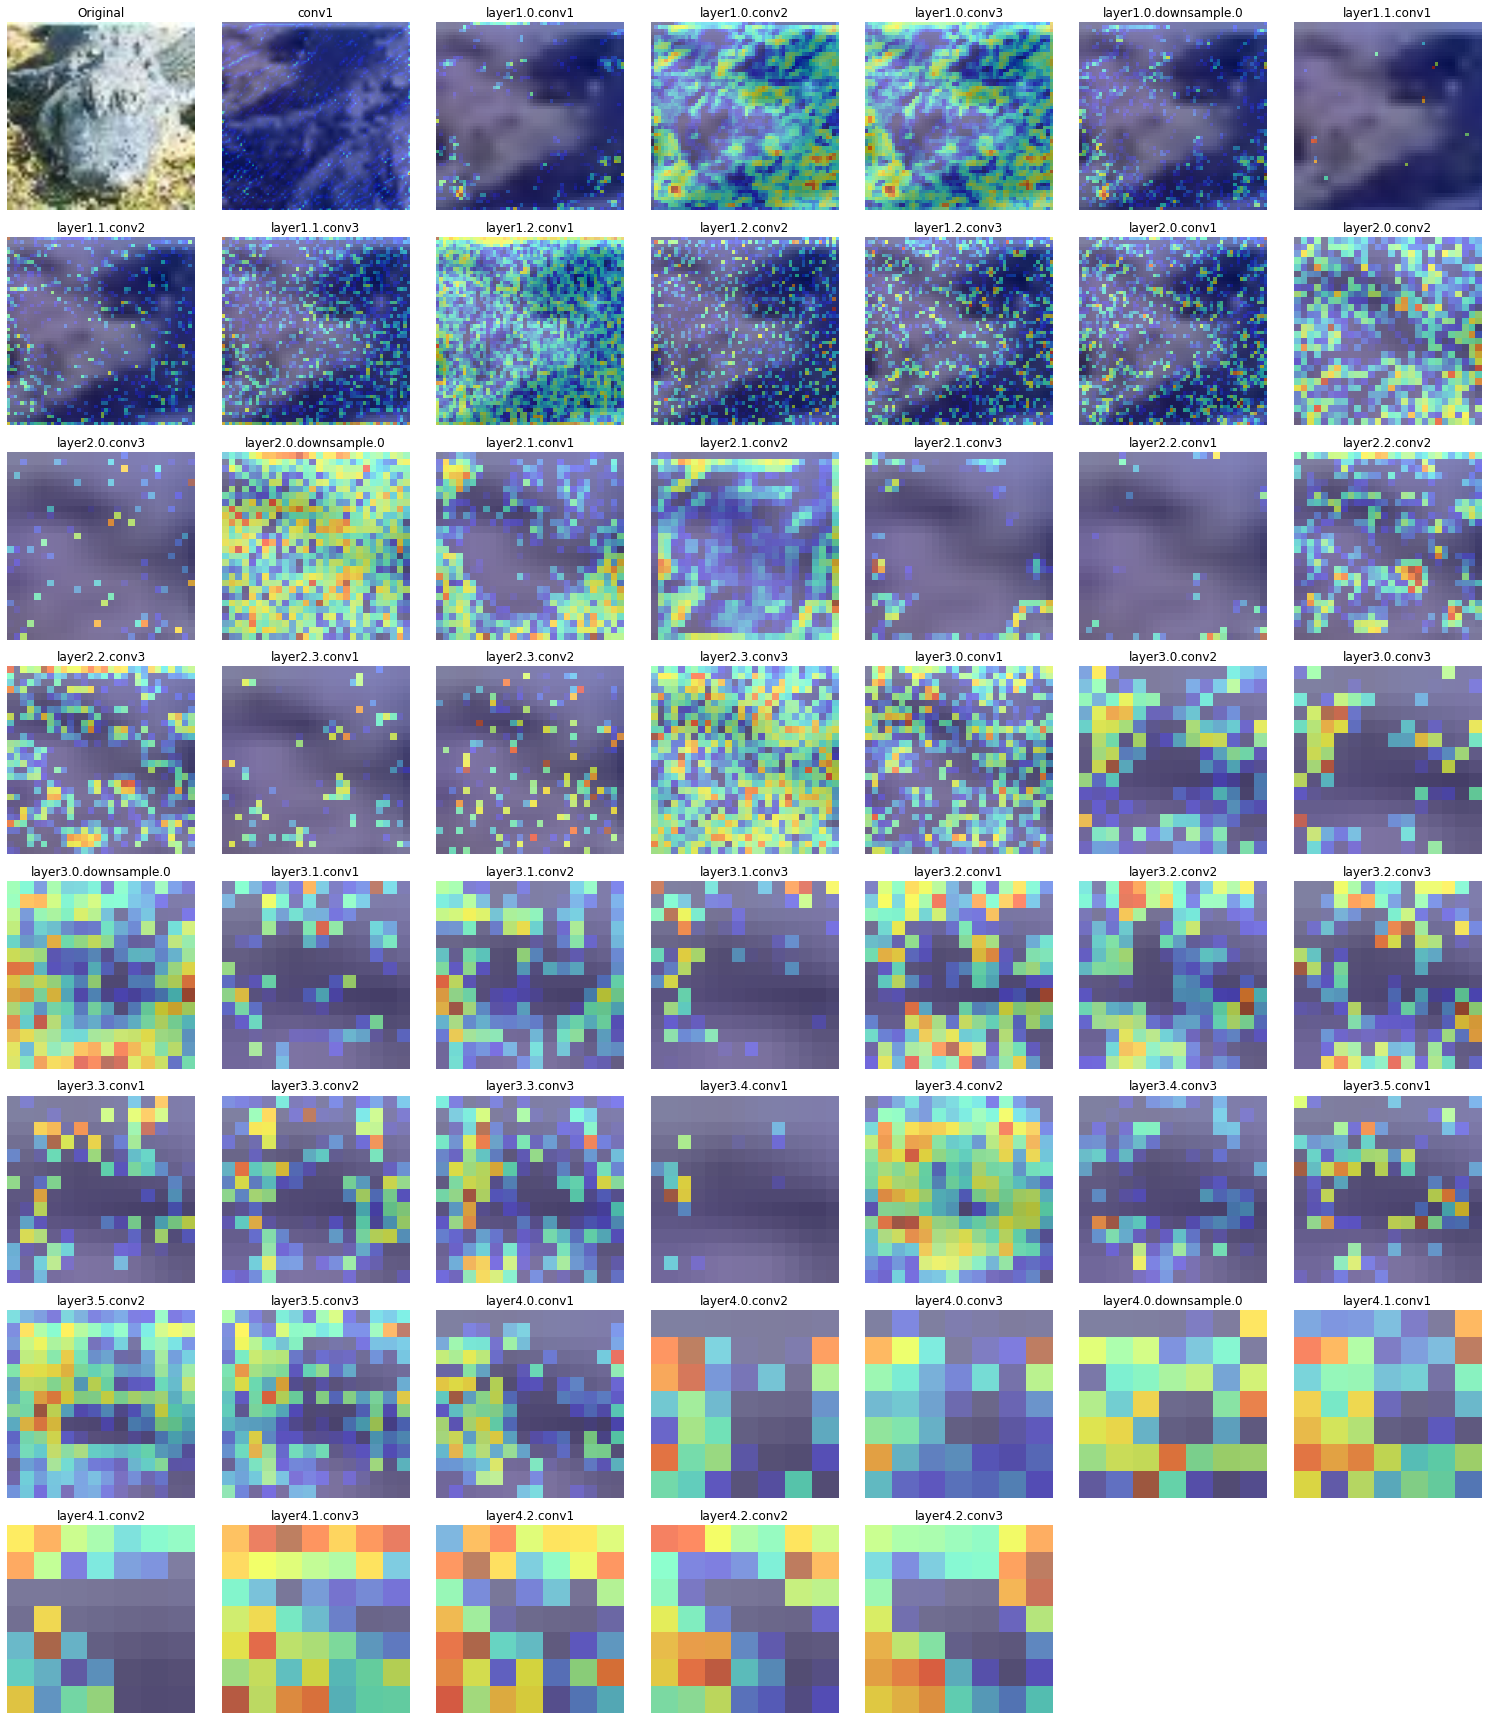

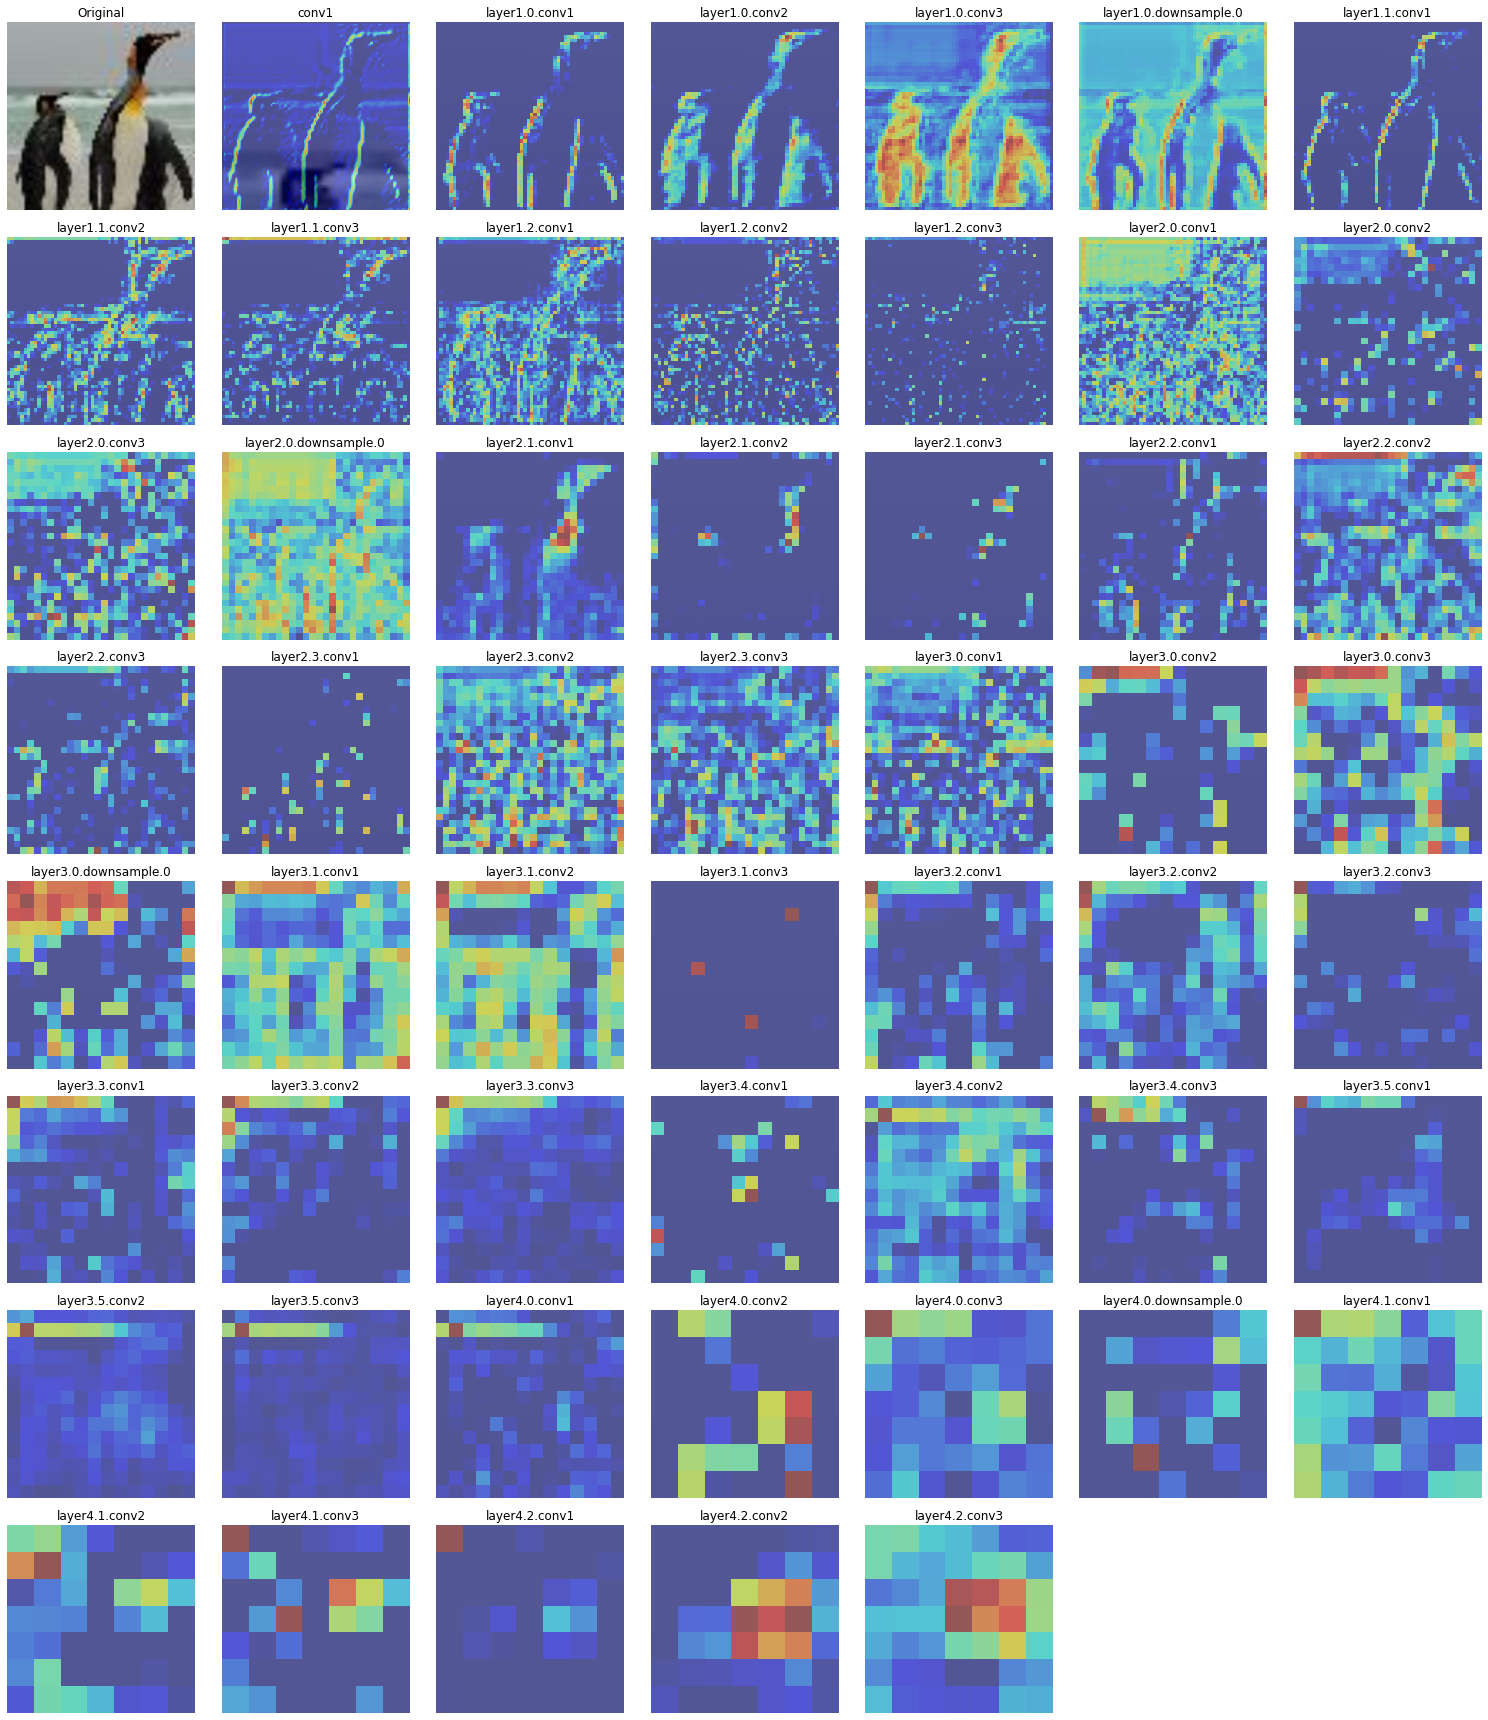

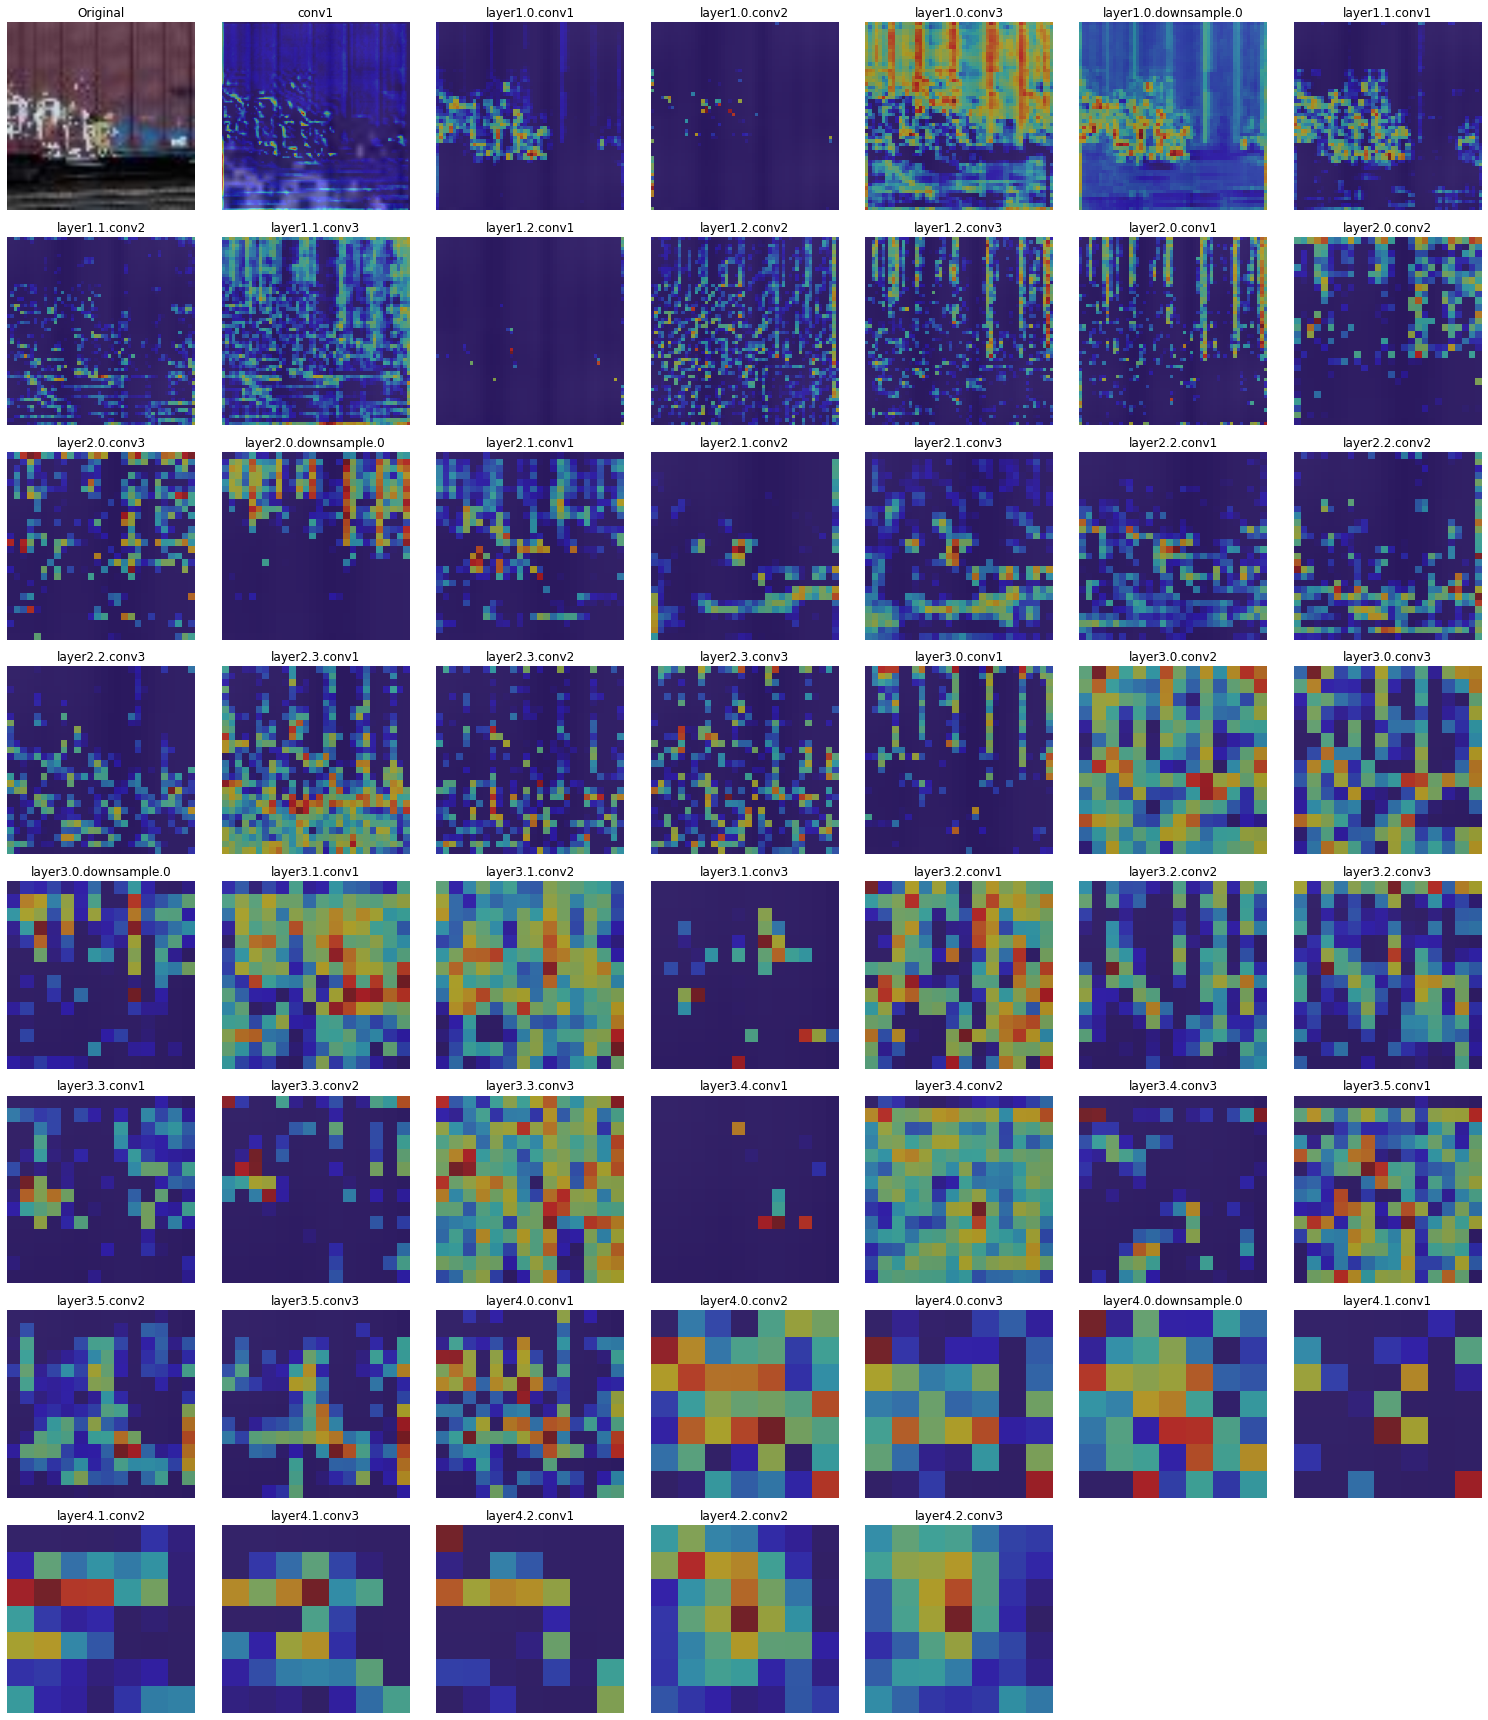

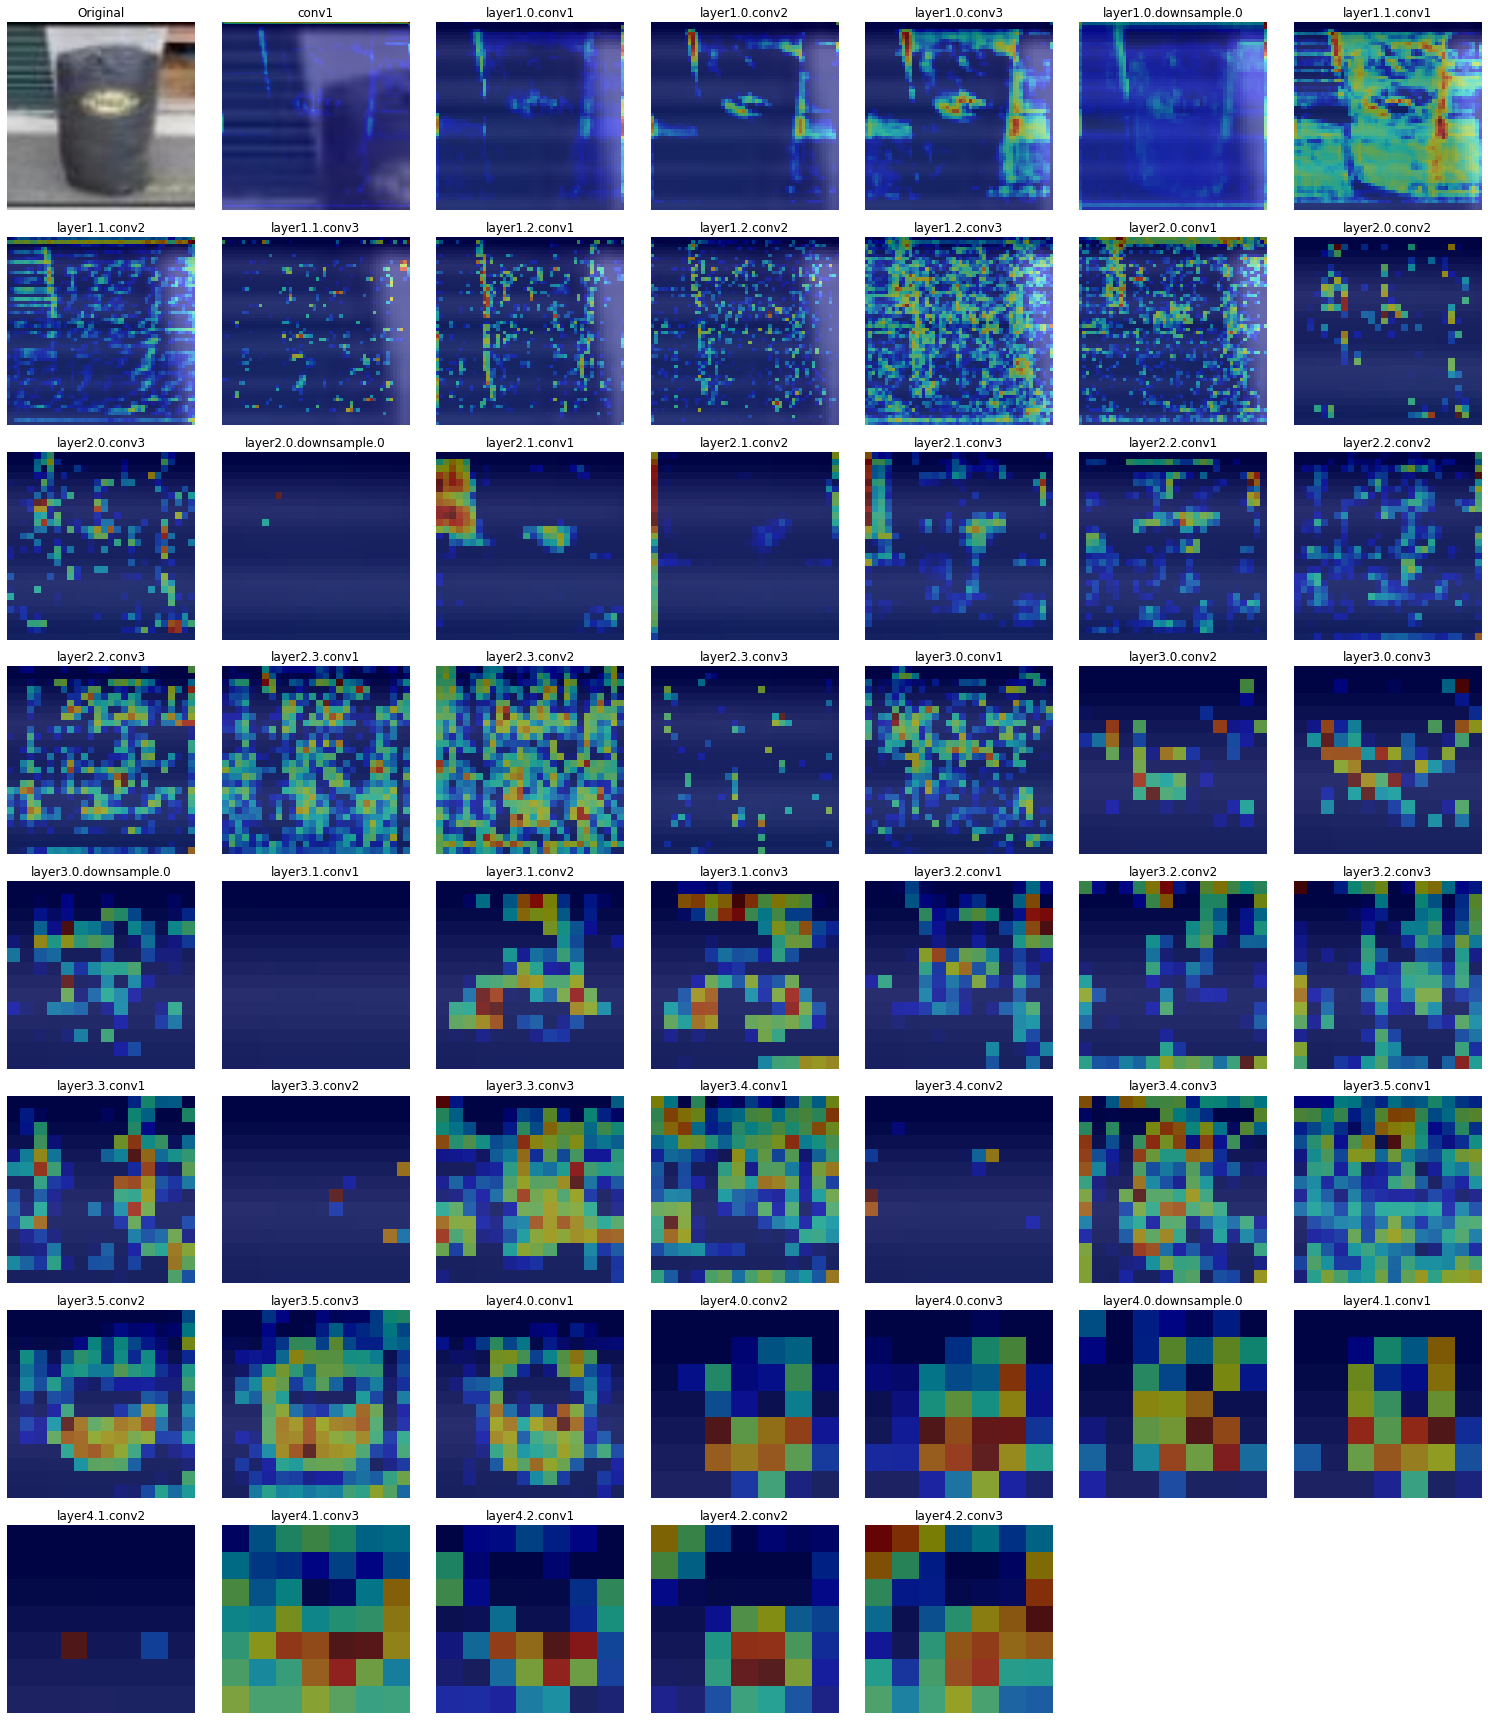

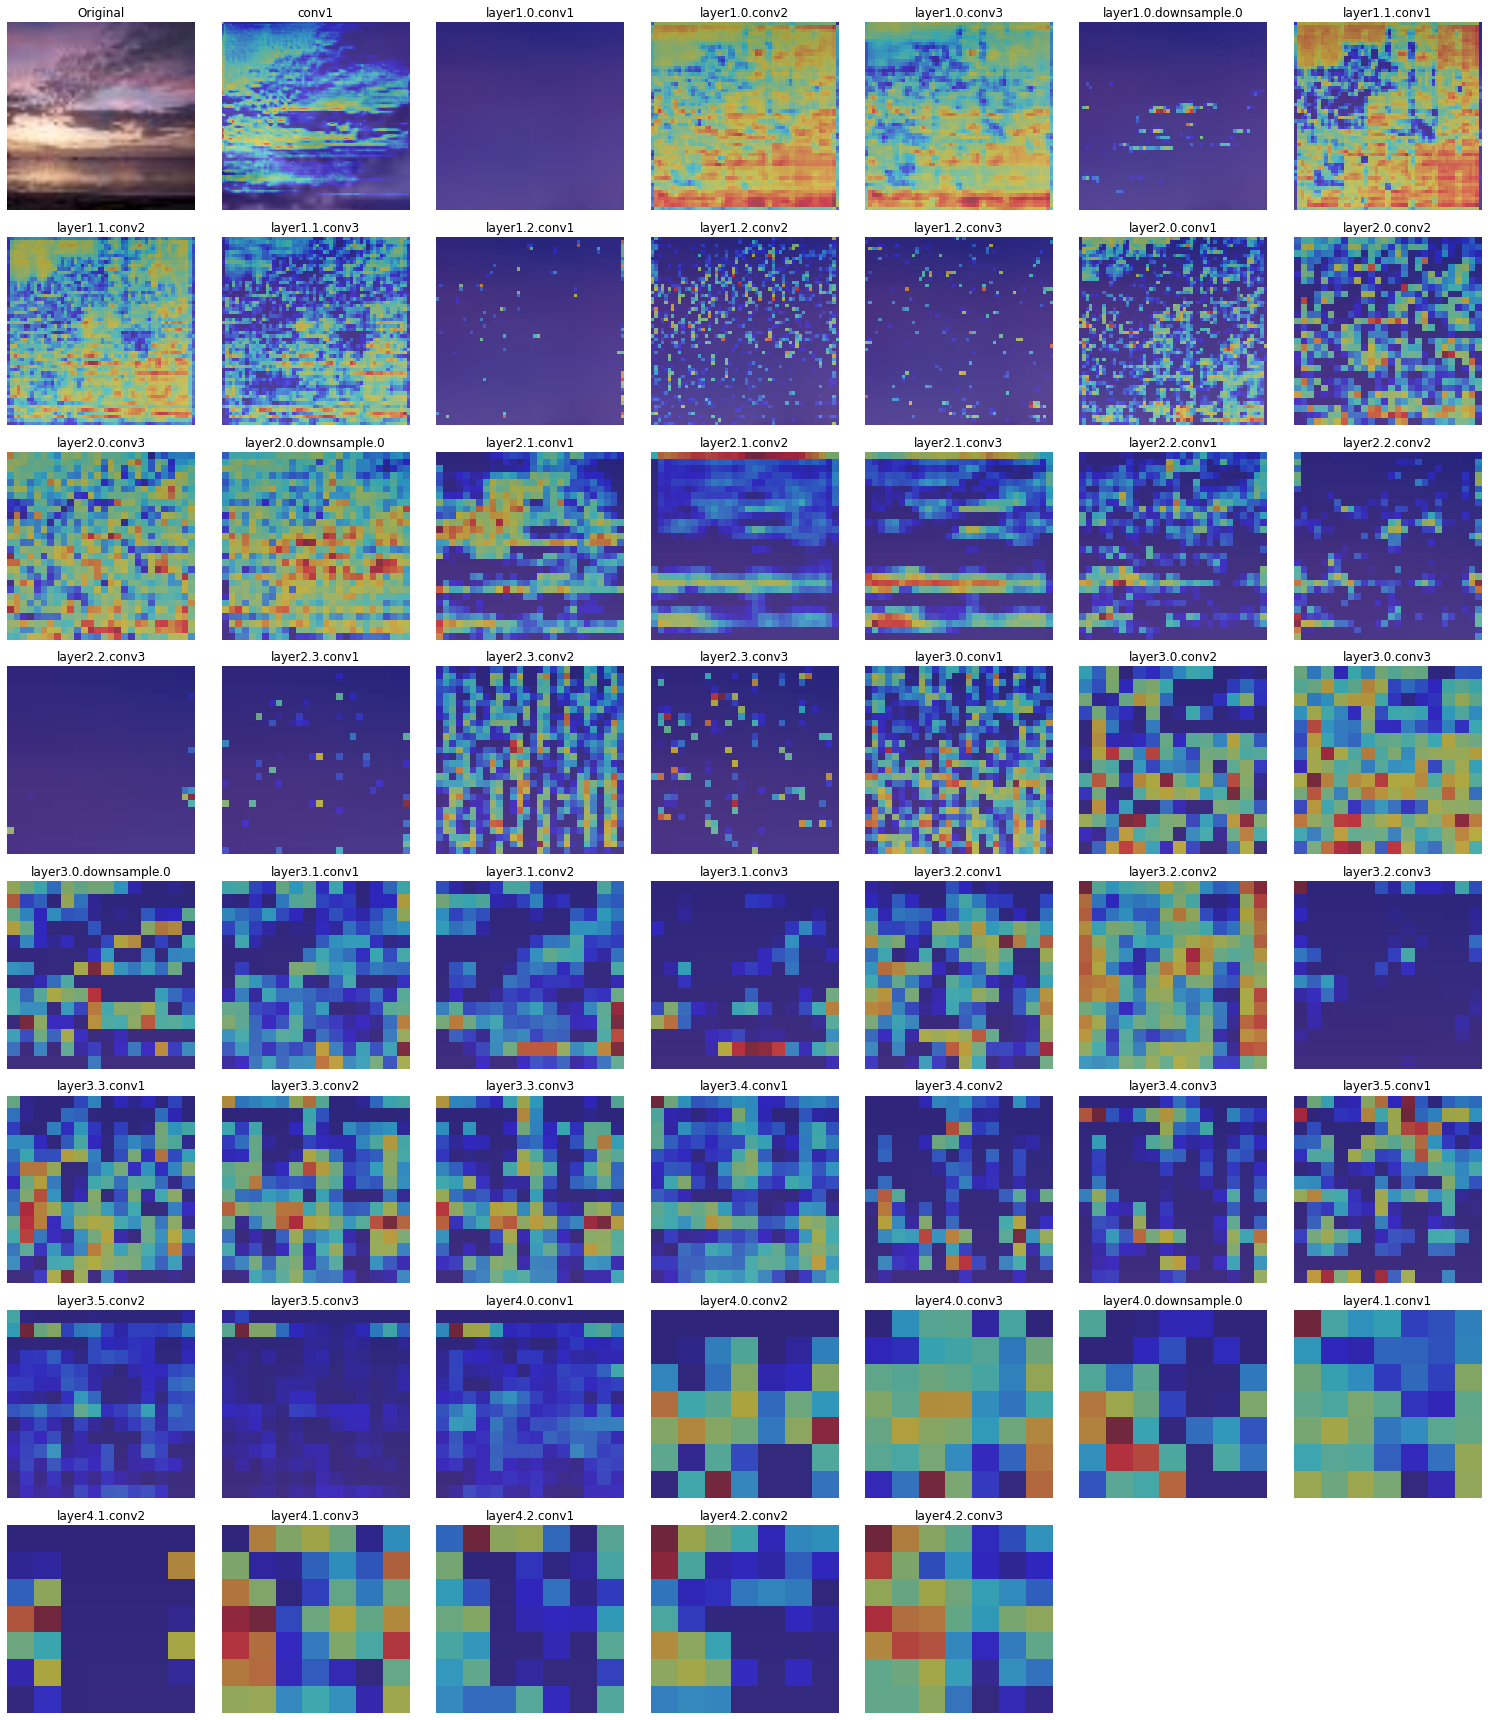

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
conv_layers = [(name, module) for name, module in model.named_modules() if isinstance(module, nn.Conv2d)]


def apply_gradcam(model, image, target_class, layers):
    model.eval()
    image = image.unsqueeze(0).to(device)
    cams = {}

    for name, layer in layers:
        activations = []
        gradients = []

        def forward_hook(module, input, output):
            activations.append(output)

        def backward_hook(module, grad_in, grad_out):
            gradients.append(grad_out[0])

        handle_f = layer.register_forward_hook(forward_hook)
        handle_b = layer.register_full_backward_hook(backward_hook)

        output = model(image)
        class_score = output[0, target_class]
        model.zero_grad()
        class_score.backward(retain_graph=True)

        handle_f.remove()
        handle_b.remove()

        if not activations or not gradients:
            continue

        act = activations[0].detach()
        grad = gradients[0].detach()
        weights = grad.mean(dim=(2, 3), keepdim=True)
        cam = (weights * act).sum(dim=1)
        cam = torch.relu(cam)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-6)
        cams[name] = cam

    return cams

for idx in range(5):
    img_tensor, label = val_dataset[random.randint(0, len(val_dataset)-1)]
    img_for_model = img_tensor.to(device)
    output = model(img_for_model.unsqueeze(0))
    predicted_class = torch.argmax(output, dim=1).item()


    img_np = img_tensor.numpy().transpose(1, 2, 0)
    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_np = np.clip(img_np, 0, 1)


    cams = apply_gradcam(model, img_tensor, predicted_class, conv_layers)

    n = len(cams)
    cols = 7
    rows = int(np.ceil((n + 1) / cols))

    plt.figure(figsize=(cols * 3, rows * 3))


    plt.subplot(rows, cols, 1)
    plt.imshow(img_np)
    plt.title("Original")
    plt.axis("off")


    for i, (layer_name, cam) in enumerate(cams.items()):
        plt.subplot(rows, cols, i + 2)
        plt.imshow(img_np)
        plt.imshow(cam, cmap='jet', alpha=0.5)
        plt.title(layer_name)
        plt.axis("off")

    plt.tight_layout()
    plt.show()